In [1]:
#!python data.py

In [2]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 112.2 MB/s eta 0:00:00


Epoch [1/10], Train Loss: 0.0313, Train Acc: 98.05%, Test Loss: 0.0000, Test Acc: 100.00%
Epoch [2/10], Train Loss: 0.0003, Train Acc: 100.00%, Test Loss: 0.0000, Test Acc: 100.00%
Epoch [3/10], Train Loss: 0.0000, Train Acc: 100.00%, Test Loss: 0.0000, Test Acc: 100.00%
Epoch [4/10], Train Loss: 0.0000, Train Acc: 100.00%, Test Loss: 0.0000, Test Acc: 100.00%
Epoch [5/10], Train Loss: 0.0000, Train Acc: 100.00%, Test Loss: 0.0000, Test Acc: 100.00%
Epoch [6/10], Train Loss: 0.0000, Train Acc: 100.00%, Test Loss: 0.0000, Test Acc: 100.00%
Epoch [7/10], Train Loss: 0.0000, Train Acc: 100.00%, Test Loss: 0.0000, Test Acc: 100.00%
Epoch [8/10], Train Loss: 0.0000, Train Acc: 100.00%, Test Loss: 0.0000, Test Acc: 100.00%
Epoch [9/10], Train Loss: 0.0000, Train Acc: 100.00%, Test Loss: 0.0000, Test Acc: 100.00%
Epoch [10/10], Train Loss: 0.0000, Train Acc: 100.00%, Test Loss: 0.0000, Test Acc: 100.00%


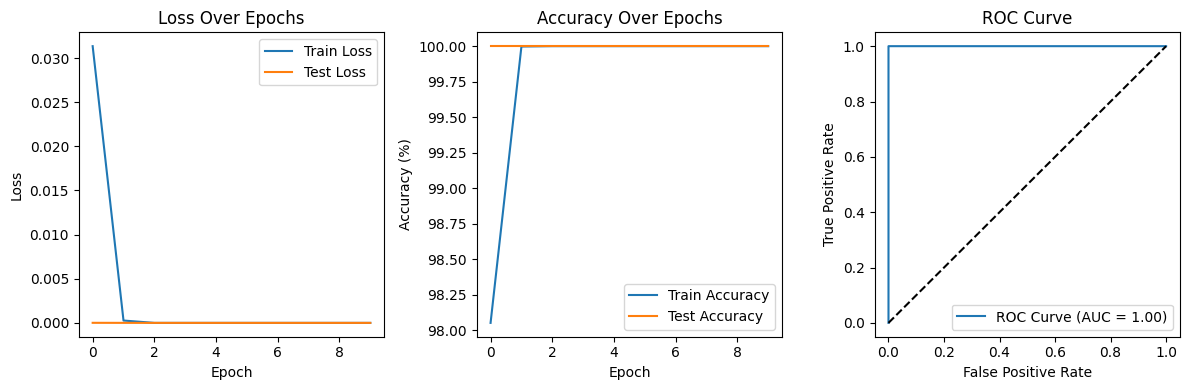

/usr/local/lib/python3.11/dist-packages/torch/onnx/symbolic_opset9.py:4277: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


Model saved to lstm_attention_model.onnx
Number of detected anomalies: 20067


In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.onnx

# تنظیم دستگاه (GPU یا CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. خواندن داده‌ها از فایل CSV
def load_data(csv_file, time_steps):
    # خواندن فایل CSV


    df=pd.read_csv(csv_file)

    df['emulsion_risk'] = np.random.randint(0, 2, size=(df.shape[0],))



    map_dict = {
      'sandstone': 0,
        'shale': 1,
        'limestone': 2
    }
    # اعمال نگاشت به ستون
    df['rock_type'] = df['rock_type'].map(map_dict)



    # ویژگی‌ها و برچسب‌ها
    features = df.columns
    labels_col = 'emulsion_risk'


    # استخراج داده‌ها
    X = df[features].values
    y = df[labels_col].values

    # اطمینان از اینکه تعداد داده‌ها مضرب time_steps است
    n_samples = len(X) // time_steps
    X = X[:n_samples * time_steps].reshape(n_samples, time_steps, len(features))
    y = y[:n_samples * time_steps:time_steps]  # یک برچسب برای هر سری زمانی

    # استانداردسازی داده‌ها
    scaler = StandardScaler()
    X = X.reshape(-1, len(features))
    X = scaler.fit_transform(X)
    X = X.reshape(n_samples, time_steps, len(features))

    return X, y, scaler,df

# مسیر فایل CSV و تعداد زمان‌گام‌ها
csv_file = "synthetic_drilling_data.csv"  # مسیر فایل CSV خود را وارد کنید
time_steps = 50
data, labels, scaler,df = load_data(csv_file, time_steps)

# 2. تعریف دیتاست سفارشی
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 3. تقسیم داده‌ها به train و test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 4. تعریف مکانیزم Attention
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output):
        attention_scores = self.attention(lstm_output).squeeze(-1)
        attention_weights = torch.softmax(attention_scores, dim=-1)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), lstm_output).squeeze(1)
        return context_vector, attention_weights

# 5. تعریف مدل LSTM با Attention
class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        context_vector, attention_weights = self.attention(lstm_output)
        output = self.fc(context_vector)
        return output, attention_weights

# 6. تنظیم مدل
input_dim = len(df.columns)
hidden_dim = 64
num_layers = 2
output_dim = 2
model = LSTMWithAttention(input_dim, hidden_dim, num_layers, output_dim).to(device)

# 7. تعریف تابع زیان و بهینه‌ساز
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 8. آموزش مدل با ثبت Loss و Accuracy
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        # آموزش
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # ارزیابی
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

    return train_losses, test_losses, train_accuracies, test_accuracies

# 9. ارزیابی مدل
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs, _ = model(data)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

# 10. تشخیص رفتار غیرعادی
def detect_anomalies(model, data_loader, threshold=0.5):
    model.eval()
    anomalies = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            outputs, _ = model(data)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            anomalies.extend((probs > threshold).cpu().numpy())
    return np.array(anomalies)

# 11. محاسبه ROC و AUC
def compute_roc_auc(model, test_loader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs, _ = model(data)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# 12. رسم نمودارها
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, fpr, tpr, roc_auc):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

# اجرای آموزش و ارزیابی
train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

# محاسبه ROC و AUC
fpr, tpr, roc_auc = compute_roc_auc(model, test_loader)

# رسم نمودارها
plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, fpr, tpr, roc_auc)

# 13. ذخیره مدل به فرمت ONNX
def export_to_onnx(model, input_dim, time_steps, filename="lstm_attention_model.onnx"):
    model.eval()
    dummy_input = torch.randn(1, time_steps, input_dim).to(device)
    torch.onnx.export(
        model,
        dummy_input,
        filename,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output', 'attention_weights'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )
    print(f"Model saved to {filename}")

# ذخیره مدل
export_to_onnx(model, input_dim, time_steps)

# تشخیص رفتار غیرعادی
anomalies = detect_anomalies(model, test_loader)
print(f"Number of detected anomalies: {np.sum(anomalies)}")